Library Dibutuhkan

In [1]:
import numpy as np
import os
import cv2
import csv
import time
import random
import shutil
import stat
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split


Variabel Independen

In [2]:
reso = 30
epochs=500
batch_size=32
neurons=64


Setup Input foto

Processing photo: 10/300 - C:\Users\matth\OneDrive - UNIVERSITAS INDONESIA\bantai pemod\etc\customres\Abdil\Abdil (13).jpg
Photo saved to output directory: C:\Users\matth\OneDrive - UNIVERSITAS INDONESIA\bantai pemod\etc\cutphotocv3\Abdil\Abdil (13).jpg
Processing photo: 20/300 - C:\Users\matth\OneDrive - UNIVERSITAS INDONESIA\bantai pemod\etc\customres\Moses\Moses (19).jpg
Photo saved to output directory: C:\Users\matth\OneDrive - UNIVERSITAS INDONESIA\bantai pemod\etc\cutphotocv3\Moses\Moses (19).jpg
Processing photo: 30/300 - C:\Users\matth\OneDrive - UNIVERSITAS INDONESIA\bantai pemod\etc\customres\Moses\Moses (17).jpg
Photo saved to output directory: C:\Users\matth\OneDrive - UNIVERSITAS INDONESIA\bantai pemod\etc\cutphotocv3\Moses\Moses (17).jpg
Processing photo: 40/300 - C:\Users\matth\OneDrive - UNIVERSITAS INDONESIA\bantai pemod\etc\customres\John\john (11).png
Photo saved to output directory: C:\Users\matth\OneDrive - UNIVERSITAS INDONESIA\bantai pemod\etc\cutphotocv3\John\jo

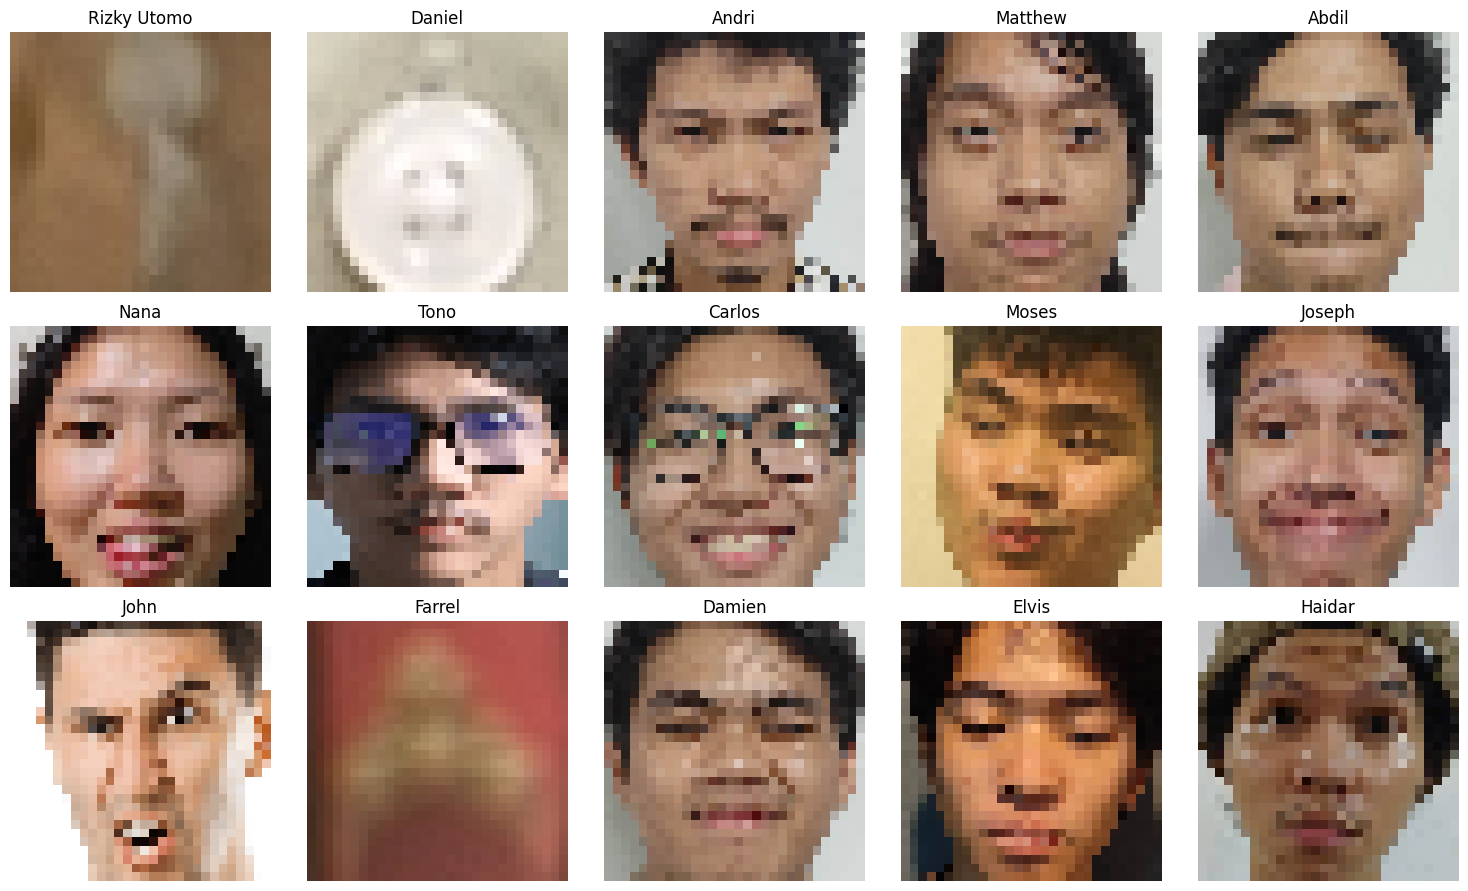

In [3]:
def clean_output_directory(output_dir):
    if os.path.exists(output_dir):
        for root, dirs, files in os.walk(output_dir):
            for file in files:
                file_path = os.path.join(root, file)
                os.chmod(file_path, stat.S_IWRITE)  # Change the permission to allow write
                os.remove(file_path)
            for dir in dirs:
                dir_path = os.path.join(root, dir)
                os.chmod(dir_path, stat.S_IWRITE)  # Change the permission to allow write
                shutil.rmtree(dir_path)
        os.rmdir(output_dir)  # Remove the output directory itself

def process_image(input_image_path, output_image_path, sample_faces, unique_names):
    # Load the image
    image = cv2.imread(input_image_path)

    # Load the pre-trained face detector
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detect faces in the image
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(reso, reso))

    if len(faces) == 0:
        # No faces detected, resize the entire image
        resized_image = cv2.resize(image, (reso, reso))
        cv2.imwrite(output_image_path, resized_image)
        return False, resized_image  # Return False as no face was detected, but the image is saved
    else:
        # Get the name from the path
        name = os.path.basename(os.path.dirname(input_image_path))

        # Save the cropped face to the output directory
        for (x, y, w, h) in faces:
            # Crop the face
            face = image[y:y+h, x:x+w]

            # Resize the cropped face to 50x50 pixels
            face_resized = cv2.resize(face, (reso, reso))

            # Save the cropped and resized face to the specified path
            cv2.imwrite(output_image_path, face_resized)

            # Add the face to the sample list if the name is unique and we have fewer than 15 samples
            if name not in unique_names and len(sample_faces) < 15:
                sample_faces.append((name, face_resized))
                unique_names.add(name)

            return True, face_resized  # Return True if a face is detected and saved

def process_directory(input_dir, output_dir):
    # Clean the output directory before processing
    clean_output_directory(output_dir)

    photo_count = 0  # Initialize a counter for the number of photos processed
    detected_count = 0  # Initialize a counter for the number of faces detected
    saved_photo_count = 0  # Initialize a counter for the number of photos saved to the output directory
    no_face_photos = []  # List to store paths of photos with no detected faces
    sample_faces = []  # List to store sample faces
    unique_names = set()  # Set to store unique names for samples

    # Get the total number of photos in the input directory
    total_photos = sum([len(files) for r, d, files in os.walk(input_dir) if any(f.lower().endswith(('png', 'jpg', 'jpeg')) for f in files)])

    all_photos = []

    for root, dirs, files in os.walk(input_dir):
        for file in files:
            if file.lower().endswith(('png', 'jpg', 'jpeg')):
                all_photos.append((root, file))

    # Shuffle the list of all photos
    random.shuffle(all_photos)

    for photo_count, (root, file) in enumerate(all_photos, start=1):
        input_image_path = os.path.join(root, file)
        relative_path = os.path.relpath(input_image_path, input_dir)
        output_image_path = os.path.join(output_dir, relative_path)

        # Print the current photo being processed with the total number of photos
        if photo_count % 10 == 0 and photo_count != 1:
            print(f"Processing photo: {photo_count}/{total_photos} - {input_image_path}")


        # Ensure the output directory exists
        os.makedirs(os.path.dirname(output_image_path), exist_ok=True)

        # Process the image
        face_detected, face_resized = process_image(input_image_path, output_image_path, sample_faces, unique_names)
        if face_detected:
            detected_count += 1
        else:
            no_face_photos.append(input_image_path)  # Log the photo with no face detected

        saved_photo_count += 1  # Increment the saved photo count
        if photo_count % 10 == 0 and photo_count != 1:
            print(f"Photo saved to output directory: {output_image_path}")

    # Print summary and photos with no faces detected
    print(f"Total photos processed: {photo_count}")
    print(f"Total faces detected: {detected_count}")
    print(f"Total photos saved to output directory: {saved_photo_count}")
    print("Photos with no faces detected:")
    for photo in no_face_photos:
        print(photo)

    # Shuffle sample faces to ensure randomness in the printout
    random.shuffle(sample_faces)

    # Display sample faces
    if sample_faces:
        fig, axs = plt.subplots(3, 5, figsize=(15, 9))
        axs = axs.flatten()
        for ax, (name, face) in zip(axs, sample_faces):
            ax.imshow(cv2.cvtColor(face, cv2.COLOR_BGR2RGB))
            ax.set_title(name)
            ax.axis('off')
        plt.tight_layout()
        plt.show()

if __name__ == "__main__":
    input_dir = r'C:\Users\matth\OneDrive - UNIVERSITAS INDONESIA\bantai pemod\etc\customres'
    output_dir = r'C:\Users\matth\OneDrive - UNIVERSITAS INDONESIA\bantai pemod\etc\cutphotocv3'
    
    process_directory(input_dir, output_dir)

Mengolah dan processing foto

In [4]:
# Function to one-hot encode labels
def one_hot_encode(labels, num_classes):
    return np.eye(num_classes)[np.array(labels, dtype=int)]

# Function to convert an image to a flattened vector
def image_to_vector(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError(f"Image not found or unable to load: {image_path}")
    return image.flatten() / 255.0

# Function to save vectors to a CSV file
def save_vectors_to_csv(vectors, file_path):
    np.savetxt(file_path, vectors, delimiter=",")

# Function to save labels to a CSV file
def save_labels_to_csv(labels, file_path):
    with open(file_path, 'w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        for label in labels:
            writer.writerow([label])

# Function to process images from the input directory and save vectors and labels to CSV files
def process_images(input_dir, output_dir):
    vectors, labels, image_paths = [], [], []
    for root, _, files in os.walk(input_dir):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_path = os.path.join(root, file)
                vectors.append(image_to_vector(image_path))
                labels.append(os.path.basename(root))
                image_paths.append(image_path)
    os.makedirs(output_dir, exist_ok=True)
    save_vectors_to_csv(np.array(vectors), os.path.join(output_dir, 'vector_x.csv'))
    save_labels_to_csv(labels, os.path.join(output_dir, 'vector_y.csv'))
    return image_paths, labels

# Function to load data from CSV files
def load_data(x_file_path, y_file_path):
    X = np.loadtxt(x_file_path, delimiter=',')
    with open(y_file_path, 'r', encoding='utf-8') as file:
        y = [row[0] for row in csv.reader(file)]
    y = np.array(y).reshape(-1, 1)  # Reshape y to ensure it has shape (300, 1)
    return X, y

# Function to binarize labels
def binarize_labels(labels):
    labels = labels.flatten().tolist()  # Convert to a flat list
    unique_labels = sorted(set(labels))  # Get sorted unique labels
    label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
    y_binary = one_hot_encode([label_to_index[label] for label in labels], len(unique_labels))
    return y_binary, unique_labels

Algoritma Backpropagation Neural Network 

In [5]:
import time
import numpy as np
import matplotlib.pyplot as plt

class BPNN:
    def __init__(self, input_size, hidden_size, output_size, dropout_rate=0.5, l2_lambda=0.01):
        self.W1 = np.random.randn(input_size, hidden_size) * np.sqrt(2. / input_size)
        self.W2 = np.random.randn(hidden_size, output_size) * np.sqrt(2. / hidden_size)
        self.b1 = np.zeros((1, hidden_size))
        self.b2 = np.zeros((1, output_size))
        self.dropout_rate = dropout_rate
        self.l2_lambda = l2_lambda

    # Rest of the class implementation remains the same

    def sigmoid(self, z):
        return 1.0 / (1.0 + np.exp(-z))

    def sigmoid_derivative(self, z):
        return z * (1 - z)

    def forward(self, X, training=True):
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = self.sigmoid(self.z1)
        if training:
            self.dropout_mask = np.random.binomial(1, self.dropout_rate, size=self.a1.shape)
            self.a1 *= self.dropout_mask
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = self.sigmoid(self.z2)
        return self.a2

    def backward(self, X, y, output, learning_rate):
        delta2 = (output - y) * self.sigmoid_derivative(output)
        dW2 = np.dot(self.a1.T, delta2) + self.l2_lambda * self.W2
        db2 = np.sum(delta2, axis=0, keepdims=True)

        delta1 = np.dot(delta2, self.W2.T) * self.sigmoid_derivative(self.a1)
        dW1 = np.dot(X.T, delta1) + self.l2_lambda * self.W1
        db1 = np.sum(delta1, axis=0, keepdims=True)

        self.W2 -= learning_rate * dW2
        self.b2 -= learning_rate * db2
        self.W1 -= learning_rate * dW1
        self.b1 -= learning_rate * db1

    def train(self, X_train, y_train, X_val, y_val, epochs, learning_rate, batch_size):
        self.error_list = []
        self.val_error_list = []  # Store validation errors
        self.error_percentage_list = []  # Store training error percentages

        for epoch in range(epochs):
            epoch_start_time = time.time()  # Start time for the epoch
            
            for i in range(0, X_train.shape[0], batch_size):
                X_batch = X_train[i:i + batch_size]
                y_batch = y_train[i:i + batch_size]
                output = self.forward(X_batch, training=True)
                self.backward(X_batch, y_batch, output, learning_rate)

            # Calculate training and validation loss
            train_loss = np.mean((y_train - self.forward(X_train, training=False)) ** 2)
            val_loss = np.mean((y_val - self.forward(X_val, training=False)) ** 2)
            
            # Calculate error percentage (assuming a classification problem)
            y_train_decoded = np.argmax(y_train, axis=1)  # Convert one-hot to class labels
            predictions = self.predict(X_train)
            error_percentage = np.mean(predictions != y_train_decoded) * 100
            
            self.error_list.append(train_loss)
            self.val_error_list.append(val_loss)
            self.error_percentage_list.append(error_percentage)

            epoch_end_time = time.time()  # End time for the epoch
            epoch_duration = epoch_end_time - epoch_start_time  # Duration of the epoch

            # Print evaluation every 100 epochs or the first epoch
            if (epoch + 1) % 100 == 0 or epoch == 0:
                performance_status = evaluate_model_performance(train_loss, val_loss)
                print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Error Percentage: {error_percentage:.2f} %, Duration: {epoch_duration:.2f}s, Status: {performance_status}")

    def predict(self, X):
        return np.argmax(self.forward(X, training=False), axis=1)

    def plot_error_percentage(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.error_percentage_list, label='Error Percentage')
        plt.xlabel('Epochs')
        plt.ylabel('Error Percentage')
        plt.title('Error Percentage over Epochs')
        plt.legend()
        plt.grid(True)
        plt.show()


Evaluasi Performa Aman, Underfitting, atau Overfitting.

In [6]:
def evaluate_model_performance(train_loss, val_loss, tolerance=0.05):
    """
    Determine if the model is overfitting, underfitting, or performing acceptably.
    """
    if train_loss > 0.7 and val_loss > 0.7:  # High loss implies underfitting
        return "Underfitting"
    elif train_loss < val_loss - tolerance:  # Large gap implies overfitting
        return "Overfitting"
    else:
        return "Acceptable"

Face Recognition Function

In [7]:
def real_time_face_recognition(bpnn, input_size, unique_labels):
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    cap = cv2.VideoCapture(0)  # Start video capture (webcam)
    
    if not cap.isOpened():
        print("Error: Camera not accessible!")
        return

    print("Press 'q' to quit.")
    
    while True:
        ret, frame = cap.read()
        if not ret:
            print("Error: Unable to read from the camera.")
            break

        # Convert frame to grayscale for face detection
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Detect faces in the frame
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

        for (x, y, w, h) in faces:
            # Extract the region of interest (face) and preprocess it
            face_roi = gray[y:y+h, x:x+w]
            resized_face = cv2.resize(face_roi, (int(input_size**0.5), int(input_size**0.5)))  # Assuming square input
            face_vector = resized_face.flatten() / 255.0
            face_vector = face_vector.reshape(1, -1)  # Ensure correct shape for prediction

            # Predict using the trained model
            pred_index = bpnn.predict(face_vector)[0]
            pred_label = unique_labels[pred_index]

            # Draw a bounding box with label
            color = (0, 255, 0)  # Green for detected faces
            cv2.rectangle(frame, (x, y), (x+w, y+h), color, 2)
            cv2.putText(frame, pred_label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

        # Display the frame with bounding boxes
        cv2.imshow('Real-Time Face Recognition', frame)

        # Quit the loop when 'q' is pressed
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

'Main' program

In [8]:
if __name__ == "__main__":
    input_dir = r'C:\Users\matth\OneDrive - UNIVERSITAS INDONESIA\bantai pemod\etc\cutphotocv3'
    output_dir = r'C:\Users\matth\OneDrive - UNIVERSITAS INDONESIA\bantai pemod\etc\pixel\tes1'
    image_paths, true_labels = process_images(input_dir, output_dir)

    x_file_path = os.path.join(output_dir, 'vector_x.csv')
    y_file_path = os.path.join(output_dir, 'vector_y.csv')
    X, y = load_data(x_file_path, y_file_path)

    print(f"X data shape: {X.shape}, y data shape: {y.shape}")

    y_binary, unique_labels = binarize_labels(y)
    print("Unique labels:", unique_labels)

    input_size = X.shape[1]
    hidden_size = neurons
    output_size = y_binary.shape[1]


    bpnn = BPNN(input_size, hidden_size, output_size)
    

# Split data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y_binary, test_size=0.2, random_state=42)

    # Train the model with validation
    bpnn.train(X_train, y_train, X_val, y_val, epochs, learning_rate=0.01, batch_size=batch_size)
    y_pred_indices = bpnn.predict(X)
    y_true = [unique_labels[idx] for idx in np.argmax(y_binary, axis=1)]
    y_pred_labels = [unique_labels[idx] for idx in y_pred_indices]

    print(f"Total images: {len(image_paths)}, Total predictions: {len(y_pred_labels)}")

X data shape: (300, 900), y data shape: (300, 1)
Unique labels: ['Abdil', 'Andri', 'Carlos', 'Damien', 'Daniel', 'Elvis', 'Farrel', 'Haidar', 'John', 'Joseph', 'Matthew', 'Moses', 'Nana', 'Rizky Utomo', 'Tono']
Epoch 1/500, Train Loss: 0.0625, Val Loss: 0.0633, Error Percentage: 95.00 %, Duration: 0.01s, Status: Acceptable
Epoch 100/500, Train Loss: 0.0651, Val Loss: 0.0655, Error Percentage: 83.75 %, Duration: 0.00s, Status: Acceptable
Epoch 200/500, Train Loss: 0.0602, Val Loss: 0.0608, Error Percentage: 50.00 %, Duration: 0.00s, Status: Acceptable
Epoch 300/500, Train Loss: 0.0542, Val Loss: 0.0548, Error Percentage: 38.33 %, Duration: 0.00s, Status: Acceptable
Epoch 400/500, Train Loss: 0.0444, Val Loss: 0.0470, Error Percentage: 33.75 %, Duration: 0.00s, Status: Acceptable
Epoch 500/500, Train Loss: 0.0345, Val Loss: 0.0395, Error Percentage: 27.50 %, Duration: 0.00s, Status: Acceptable
Total images: 300, Total predictions: 300


Sampel Hasil Proses Prediksi

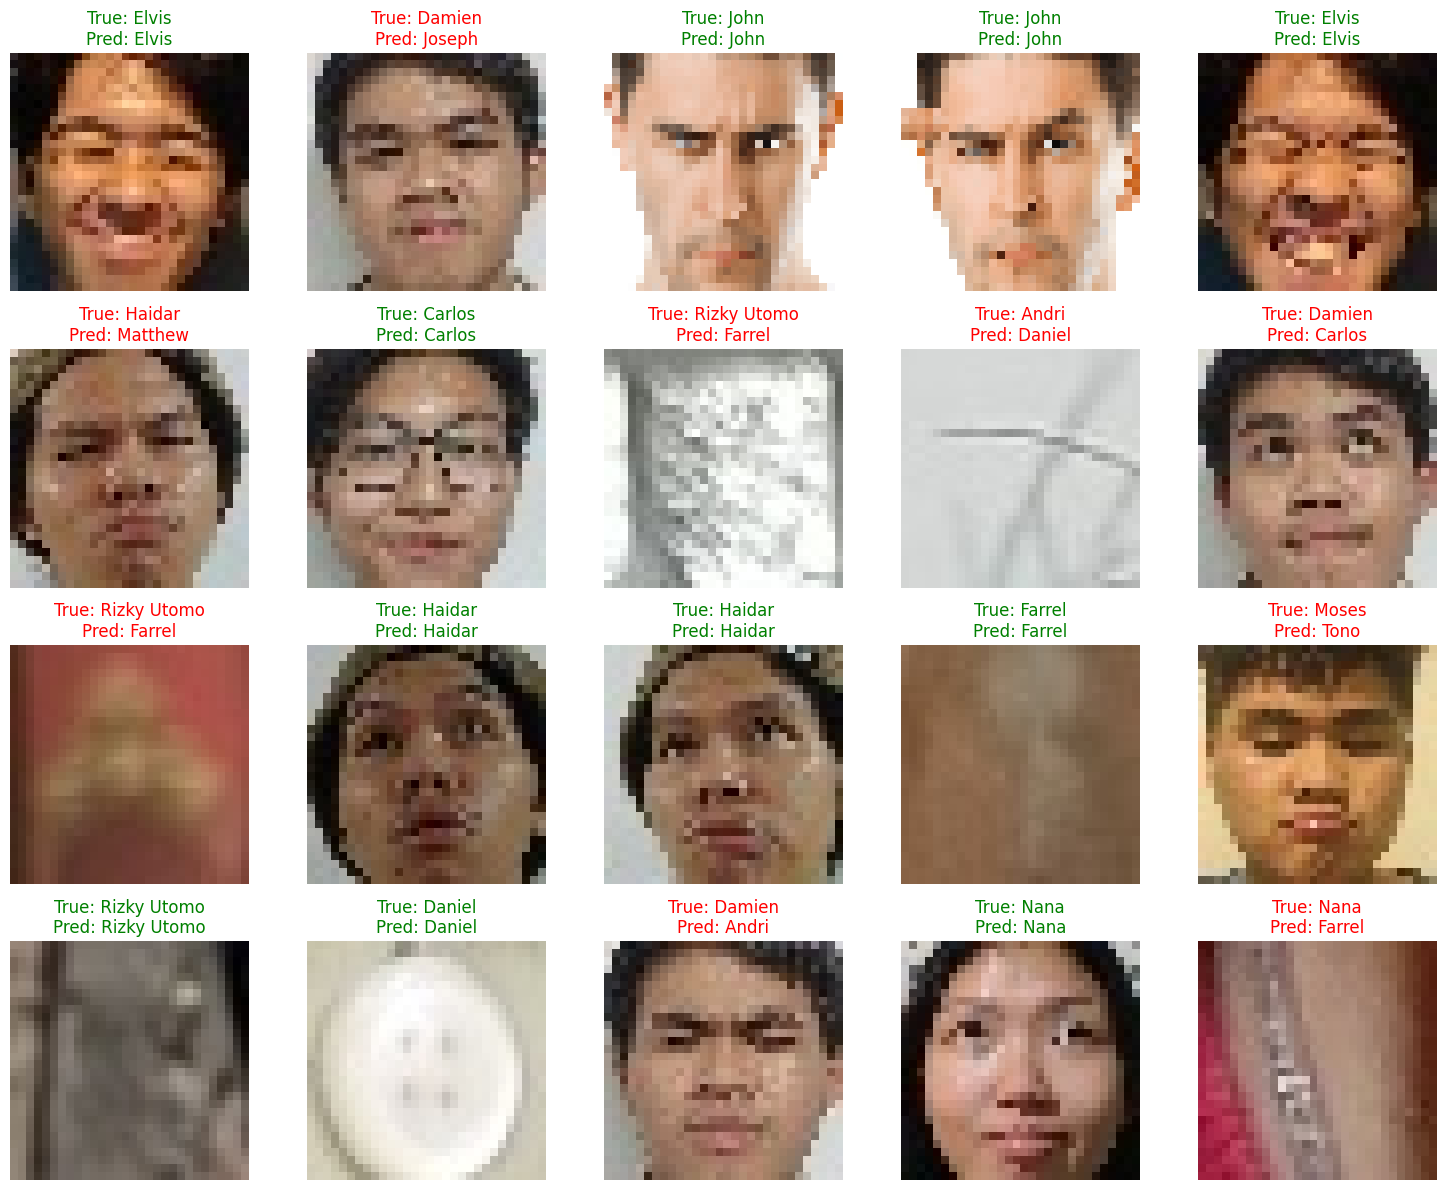

In [9]:
def generate_visualization(image_paths, true_labels, pred_labels, output_dir):
    selected_indices = random.sample(range(len(image_paths)), min(20, len(image_paths)))
    fig, axes = plt.subplots(4, 5, figsize=(15, 12))
    axes = axes.ravel()
    for idx, img_idx in enumerate(selected_indices):
        img = cv2.imread(image_paths[img_idx])
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        true_label = true_labels[img_idx]
        pred_label = pred_labels[img_idx]
        color = 'green' if true_label == pred_label else 'red'
        axes[idx].imshow(img_rgb)
        axes[idx].axis('off')
        axes[idx].set_title(f"True: {true_label}\nPred: {pred_label}", color=color)
    plt.tight_layout()
    os.makedirs(output_dir, exist_ok=True)
    plt.savefig(os.path.join(output_dir, 'visualization.png'))
    plt.show()
    
generate_visualization(image_paths, y_true, y_pred_labels, output_dir)

Training vs Validation Loss

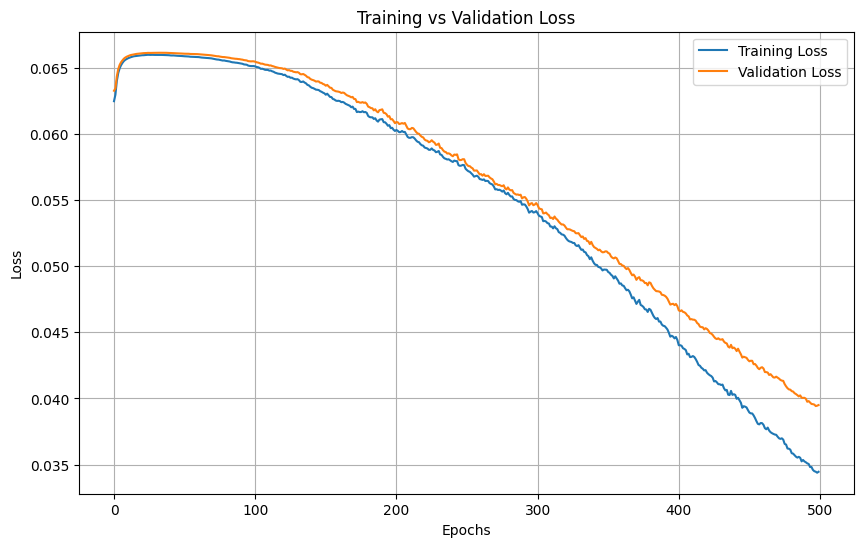

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(bpnn.error_list, label='Training Loss')
plt.plot(bpnn.val_error_list, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(output_dir, 'loss_plot.png'))
plt.show()

Plot Error percentage

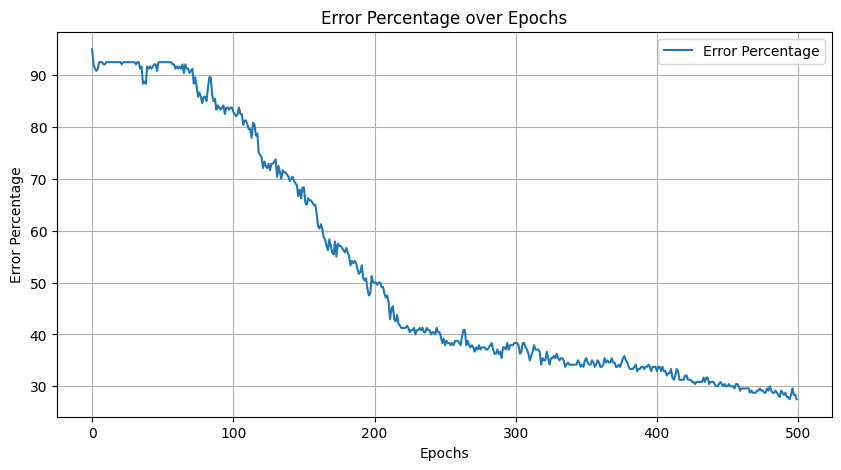

In [11]:
bpnn.plot_error_percentage()


Confusion Matrix

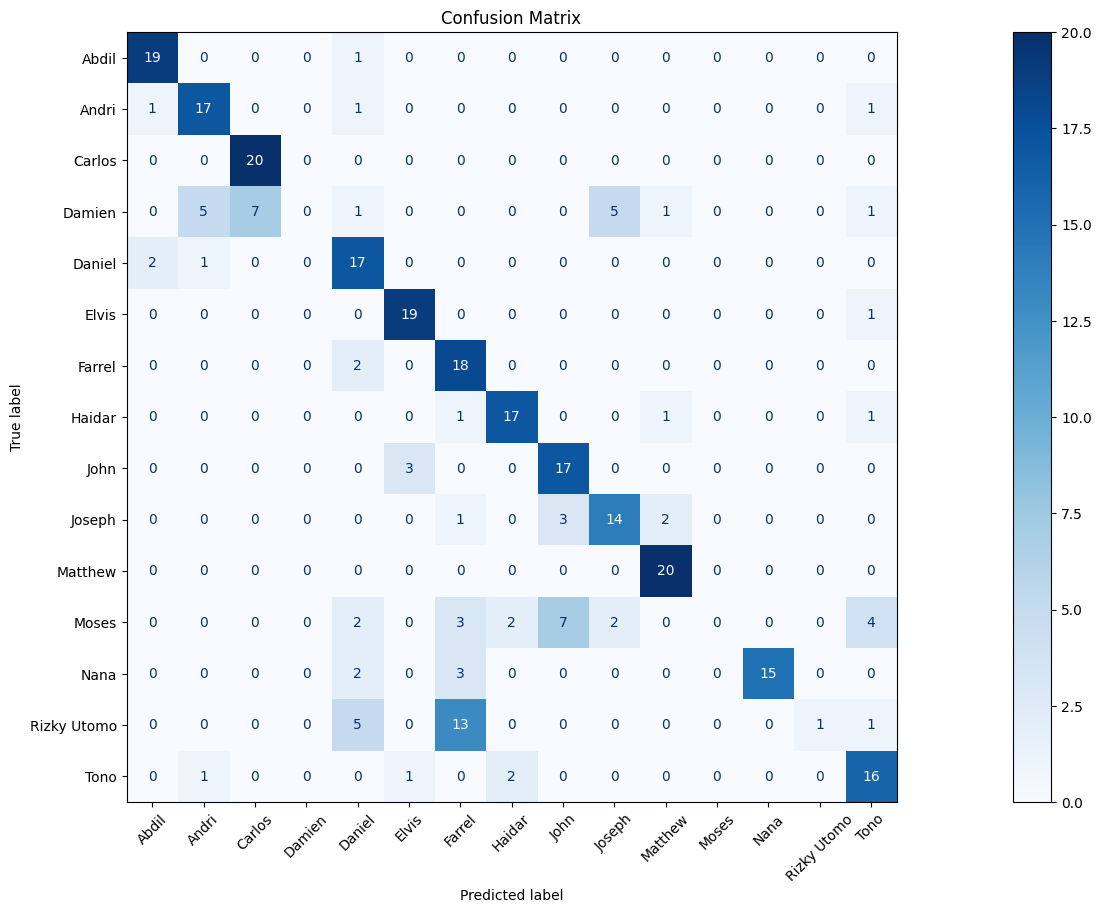

In [12]:


# Assuming y_true, y_pred_labels, and unique_labels are already defined
cm = confusion_matrix(y_true, y_pred_labels, labels=unique_labels)

# Create a larger figure explicitly
fig, ax = plt.subplots(figsize=(30, 10))  # Adjust the size (Width=12, Height=10)

# Pass the custom axis to the ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)
disp.plot(cmap=plt.cm.Blues, ax=ax)  # Pass the 'ax' to ensure it uses the larger figure

# Adjust ticks and title
plt.xticks(rotation=45)
plt.title('Confusion Matrix')
plt.show()


Face Recognition

In [13]:
real_time_face_recognition(bpnn, input_size, unique_labels)

Press 'q' to quit.
